In [3]:
#Libraries and Dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from pulp import LpProblem, LpVariable, lpSum, LpMaximize, LpStatus, value

df = pd.read_excel("Life-Expectancy-Data-Updated.xlsx", sheet_name="Life-Expectancy-Data-Updated")
columns = ['Infant_deaths', 'BMI', 'Schooling', 'Life_expectancy']
df_lp = df[columns].dropna()

In [4]:
#Regression
X = df_lp[['Infant_deaths', 'BMI', 'Schooling']]
y = df_lp['Life_expectancy']
reg = LinearRegression().fit(X, y)
coeffs = dict(zip(X.columns, reg.coef_))
intercept = reg.intercept_

print("Regression Coefficients:")
for k, v in coeffs.items():
    print(f"  {k}: {v:.4f}")
print(f"Intercept: {intercept:.4f}\n")

#Linear Programming Optimization
model = LpProblem("Maximize_Life_Expectancy", LpMaximize)
improve_infant_deaths = LpVariable("Reduce_Infant_Deaths", lowBound=0)
improve_bmi = LpVariable("Increase_BMI", lowBound=0)
improve_schooling = LpVariable("Increase_Schooling", lowBound=0)

# Costs per unit
costs = {
    'Infant_deaths': 5,
    'BMI': 2,
    'Schooling': 3
}
total_budget = 100  # Total budget to optimize

# Objective: Maximize life expectancy gain
model += (
    -coeffs['Infant_deaths'] * improve_infant_deaths +
     coeffs['BMI'] * improve_bmi +
     coeffs['Schooling'] * improve_schooling,
    "Total_Life_Expectancy_Gain"
)

# Budget constraint
model += (
    costs['Infant_deaths'] * improve_infant_deaths +
    costs['BMI'] * improve_bmi +
    costs['Schooling'] * improve_schooling <= total_budget,
    "BudgetConstraint"
)

# Solve
model.solve()

# Print resukts
print(f"Status: {LpStatus[model.status]}\n")
print(f"Optimal allocation under budget ${total_budget}:")
print(f"  Reduce infant deaths by: {improve_infant_deaths.varValue:.2f} units")
print(f"  Increase BMI by: {improve_bmi.varValue:.2f} units")
print(f"  Increase Schooling by: {improve_schooling.varValue:.2f} years")
print(f"\nEstimated life expectancy gain: {value(model.objective):.2f} years\n")


Regression Coefficients:
  Infant_deaths: -0.3127
  BMI: -0.1035
  Schooling: 0.0766
Intercept: 80.3576

Status: Optimal

Optimal allocation under budget $100:
  Reduce infant deaths by: 20.00 units
  Increase BMI by: 0.00 units
  Increase Schooling by: 0.00 years

Estimated life expectancy gain: 6.25 years



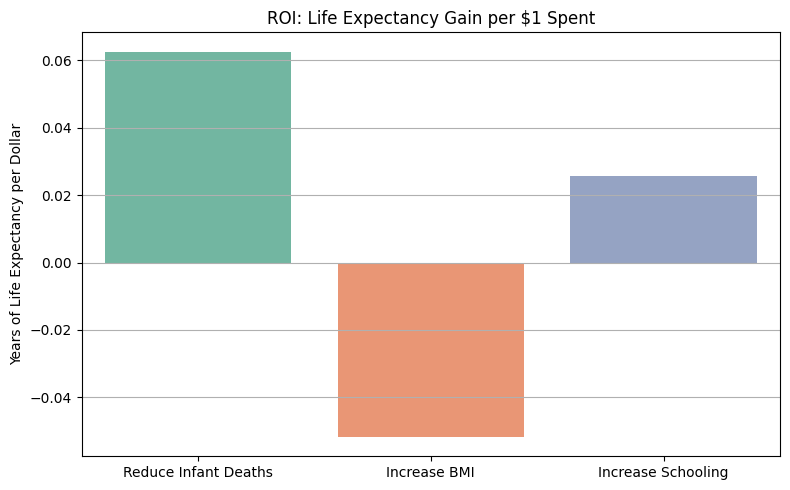

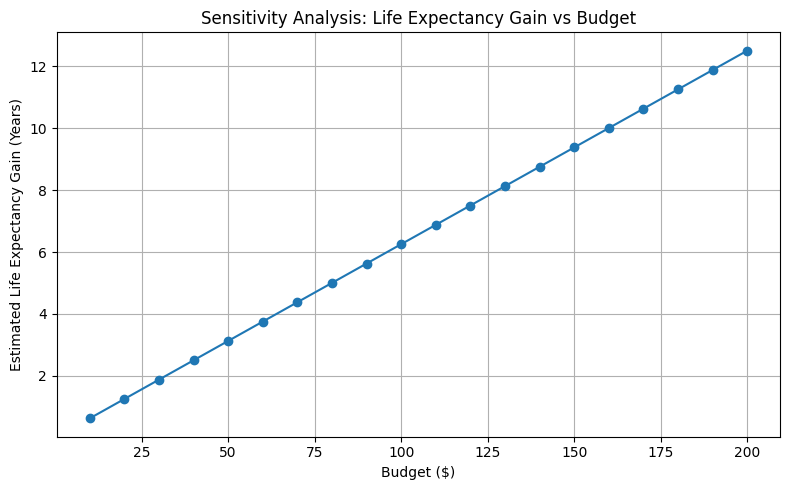

In [5]:
# PLOTS
roi_data = {
    "Intervention": ["Reduce Infant Deaths", "Increase BMI", "Increase Schooling"],
    "Impact per Unit": [-coeffs['Infant_deaths'], coeffs['BMI'], coeffs['Schooling']],
    "Cost per Unit ($)": [costs['Infant_deaths'], costs['BMI'], costs['Schooling']]
}
roi_df = pd.DataFrame(roi_data)
roi_df["Life Expectancy Gain per $1"] = roi_df["Impact per Unit"] / roi_df["Cost per Unit ($)"]

# Plot ROI bar chart
plt.figure(figsize=(8, 5))
sns.barplot(
    data=roi_df,
    x="Intervention",
    y="Life Expectancy Gain per $1",
    hue="Intervention",
    palette="Set2",
    dodge=False,
    legend=False
)
plt.title("ROI: Life Expectancy Gain per $1 Spent")
plt.ylabel("Years of Life Expectancy per Dollar")
plt.xlabel("")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Sensitivity Analysis
budgets = np.arange(10, 210, 10)
best_roi = roi_df["Life Expectancy Gain per $1"].max()
le_gains = budgets * best_roi

plt.figure(figsize=(8, 5))
plt.plot(budgets, le_gains, marker='o', linestyle='-', color='#1f77b4')
plt.title("Sensitivity Analysis: Life Expectancy Gain vs Budget")
plt.xlabel("Budget ($)")
plt.ylabel("Estimated Life Expectancy Gain (Years)")
plt.grid(True)
plt.tight_layout()
plt.show()

### **1. Objective**
The primary objective of this analysis was to **determine the most effective way to allocate a limited health budget** across different public health interventions to **maximize life expectancy**. Specifically, the study explored how investments in three factors influenced average life expectancy across countries—

a) reducing infant mortality

b) improving nutrition (BMI)

c) enhancing access to education (schooling)

By optimizing budget allocation using real-world data, we aimed to derive a data-driven recommendation for policymakers on how to prioritize resources for maximum public health impact.

*Basically, we wanted to maximum life expectancy by minimizing budget. This is a classic Linear Programming case, and so we went ahead with this method, since this was taught in the course.*

### **2. Procedure**
The analysis followed a structured, three-phase process:

**Phase 1: Data Preparation and Regression Modeling**

We began by exploring a life expectancy dataset containing global records on health metrics, education, economic indicators, and mortality rates. After cleaning the data to focus on non-missing values, we selected three key variables for intervention: Infant_deaths, BMI, and Schooling. A linear regression model was trained using these variables to predict Life_expectancy. The resulting regression coefficients quantified the marginal effect of each variable on life expectancy. The coefficients were:


*   Infant_deaths: -0.3127
*   BMI: -0.1035
*   Schooling: +0.0766


These coefficients indicated that a reduction in infant deaths and an increase in schooling positively influenced life expectancy, while an increase in BMI had a slightly negative effect in this context.

**Phase 2: Linear Programming (LP) Optimization**

Next, we used the coefficients in a linear programming (LP) model to maximize life expectancy gain under a strict budget of **\$100**. We defined three decision variables representing the number of units by which each factor could be improved. Each variable had an associated cost per unit of intervention: **\$5** for reducing infant deaths, **\$2** for improving BMI, and **\$3** for increasing schooling. The LP objective was to maximize the weighted sum of life expectancy gains based on the regression model, constrained by the total budget. The optimization was performed using the **PuLP** library.

**Phase 3: Insights and Visualization**

After solving the LP model, we visualized the results through two key plots:



1.   A bar chart showing the ROI (return on investment) in terms of years of life expectancy gained per dollar for each intervention.
2.   A sensitivity analysis line chart showing how the total expected life expectancy gain changes with increasing budget levels.





### **3. Key Findings**

- The LP solution identified that **100% of the available budget should be allocated to reducing infant deaths**, resulting in a 6.25-year increase in life expectancy.

- The ROI analysis revealed that **reducing infant deaths offers the highest return per dollar**, yielding approximately 0.0625 years per dollar invested. In contrast, schooling offers a smaller but positive return (~0.0255 years per dollar), and BMI interventions actually showed a negative return on investment.

- The sensitivity analysis demonstrated a **linear and scalable benefit** from increasing budget levels when investing exclusively in reducing infant mortality. For example, doubling the budget to $200 would result in a 12.5-year gain in life expectancy.

- The regression model confirmed that **infant mortality has the largest negative influence on life expectancy**, reaffirming its importance as a policy priority.

- BMI, which is often treated as a proxy for general nutrition, showed a mild negative effect, suggesting that high or imbalanced BMI could be associated with reduced longevity in some populations.

### **Conclusion**

This analysis provides clear and actionable insights for optimizing public health investments. The results indicate that **reducing infant mortality is the single most effective intervention** for increasing life expectancy per dollar spent. This insight holds true not only under a fixed budget but also across different budget levels, as shown in the sensitivity analysis. While educational investments have a positive effect, their return on investment is significantly lower than interventions targeting infant survival. Additionally, BMI-based interventions may need to be reassessed or targeted more precisely, as indiscriminate increases in BMI could yield diminishing or even negative returns.

In conclusion, if the goal is to achieve the maximum possible increase in life expectancy under budget constraints, **early-childhood health and survival programs should be prioritized**. This aligns with broader global health priorities and reinforces the importance of targeting high-leverage, life-saving interventions. These findings can serve as an evidence-based framework for policymakers, global health organizations, and NGOs looking to maximize the impact of limited healthcare resources.
